In [1]:
import sys
print("python",sys.version)
import torch
print("torch",torch.__version__)
print("cuda",torch.version.cuda)
print(torch.cuda.is_available())

python 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
torch 2.1.2
cuda 12.1
True


In [2]:
!pip install -q --no-cache-dir torch==2.1.2+cu121 --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q --no-cache-dir torch-geometric

In [3]:
import time
time_start = time.time()

import optuna
import math
import torch
import torch.nn as nn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm 
from torch import optim
from scipy import interpolate
from sklearn import linear_model 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data,Dataset,DataLoader

import pytz
import datetime
nowTime = datetime.datetime.now(pytz.timezone('Asia/Hong_Kong')).strftime('%Y_%m_%d_%H_%M_%S')  # Current time

# Alternative approach
torch.set_default_dtype(torch.float32)

#torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import random
from torch.backends import cudnn

def seed_torch(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # Fully reproduce, but training efficiency is low
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

In [5]:
# read data and slicing to generate training samples
def read_data(prob_No, window_size, stride, MaxRUL):
    '''
    :param prob_No: 1,2,3,4, ----representing FD001 ~ FD004
    :param window_size: sliding window size
    :param stride: slide step length
    :param MaxRUL: maximum remaining useful life
    :return: training & testing set data (dims: num x lens/or window_size x channels) & labels (dims: num x lens/or window_size) or (dims: num x lens/1)
    '''
    min_max_scaler = MinMaxScaler()  # Normalize to [0,1] default axis=0 column
    # Use axis = 0 to represent method execution along each column or row label/index value
    # Use axis = 1 value to indicate the execution of the corresponding method along each row or column label mode
    train_load = np.loadtxt('../input/nasa-cmaps/CMaps/train_FD00' + str(prob_No) + '.txt')
    test_load = np.loadtxt('../input/nasa-cmaps/CMaps/test_FD00' + str(prob_No) + '.txt')
    rul_load = np.loadtxt('../input/nasa-cmaps/CMaps/RUL_FD00' + str(prob_No) + '.txt')
    '''
    Engine number, running time, three operation modes, 21 sensors
    '''
    train_load[:, 2:] = min_max_scaler.fit_transform(train_load[:, 2:])  # Normalize (from three operation modes and 21 sensors)
    test_load[:, 2:] = min_max_scaler.transform(test_load[:, 2:])
    '''
    Engine number, running time, (three operation modes, 21 sensors) range [0-1]
    '''
    train_data = np.delete(train_load, [2, 3, 4, 5, 9, 10, 14, 20, 22, 23], axis=1)  # select sensor
    test_data = np.delete(test_load, [2, 3, 4, 5, 9, 10, 14, 20, 22, 23], axis=1)

    x = np.array(list(range(0, window_size, stride)))  # x represents time step list for time step regression
    # range (start, stop, step), create array
    # Training set
    train_data_total = []
    train_label_total = []
    unitnum1 = int(np.max(train_data[:, 0]))  # Maximum value in the first column, representing the number of training sets, 260
    LRmodel = linear_model.LinearRegression()  # Linear regression
    train_cyclen_list = []
    train_sample_num = 0

    for unit in tqdm(range(1, unitnum1 + 1), desc='Training Data Sampling FD00' + str(prob_No), ascii=False, ncols=100,
                     total=unitnum1):# One for loop, sliding window slicing 35x14, dividing a set of engine running cycle data, tqdm progress bar, traverse all engine numbers
        ind = np.where(train_data[:, 0] == unit)# Is the engine number 1? ... 2.3.4..260
        ind = ind[0]
        data = train_data[ind, 2:]# 14 sensor parameter values of engine number 1 are passed into data
        cyclens = data.shape[0]# 0 indicates the number of matrix rows, 1 indicates the number of matrix columns, indicating the total life length of the engine

        labels = [(cyclens - t if cyclens - t <= MaxRUL else MaxRUL) for t in range(1, cyclens + 1)]# Labels sliding window processing data

        if cyclens >= window_size:# Data sliding window processing
            train_cyclen_list.append(cyclens - window_size + 1)# Number of data fragments in an engine
            for i in range(0, cyclens - window_size + 1, stride):
                scaled_data = data[i:i + window_size]
                # 0-35  1-36 。。。
                train_data_total.append(scaled_data)# Collection of data slices, 30,30 per group
                train_label_total.append(torch.tensor(labels[i + window_size - 1]))

                train_sample_num += 1# Number of data fragments in an engine (data produced by sliding window of a model), accumulated to 260 engine data fragments and

    # Test set
    test_data_total = []
    test_label_total = []
    unitnum2 = int(np.max(test_data[:, 0]))
    test_cyclen_list = []
    test_sample_num = 0

    test_label = rul_load

    for unit in tqdm(range(1, unitnum2 + 1), desc='Testing Data Sampling FD00' + str(prob_No), ascii=False, ncols=100,
                     total=unitnum2):
        ind = np.where(test_data[:, 0] == unit)
        ind = ind[0]
        data = test_data[ind, 2:]
        cyclens = data.shape[0]

        if cyclens >= window_size:
            test_cyclen_list.append(cyclens - window_size + 1)
            labels = [((test_label[unit - 1] + cyclens - 1 - t)
                           if (test_label[unit - 1] + cyclens - 1 - t) <= MaxRUL else MaxRUL) for t in range(cyclens)]

            for i in range(0, cyclens - window_size + 1, stride):
                scaled_data = data[i:i + window_size]

                test_data_total.append(scaled_data)
                test_label_total.append(torch.tensor(labels[i + window_size - 1]))

                test_sample_num += 1

    return train_data_total, train_label_total, train_sample_num, train_cyclen_list, test_data_total, test_label_total, test_sample_num, test_cyclen_list

In [6]:
edge_index =[
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13],
    [1, 2, 4, 5, 6, 8, 9, 10, 11, 0, 2, 4, 5, 6, 8, 9, 10, 11, 0, 1, 4, 5, 6, 8, 9, 10, 11, 7, 12, 13, 0, 1, 2, 6, 8, 10, 11, 0, 1, 2, 6, 9, 10, 11, 0, 1, 2, 4, 5, 8, 9, 10, 11, 3, 12, 13, 0, 1, 2, 4, 6, 10, 11, 0, 1, 2, 5, 6, 10, 11, 0, 1, 2, 4, 5, 6, 8, 9, 11, 0, 1, 2, 4, 5, 6, 8, 9, 10, 3, 7, 13, 3, 7, 12]
]

In [7]:
def RULdataset(data, label, edge_index):
    data_list = []
    for i in tqdm(range(len(data))):
        x = data[i].T
        node_features = torch.tensor(x, dtype=torch.float)#float
        graph_label = torch.tensor([label[i]], dtype=torch.float)#float
        edge = torch.tensor(edge_index, dtype=torch.long)#long
        data1 = Data(x=node_features, y=graph_label, edge_index=edge)
        data_list.append(data1)

    return data_list

In [8]:
#Evaluation Metrics
def RUL_Score(y_true, y_pre):

    y_true = y_true.view(-1).detach().numpy()
    y_pre = y_pre.view(-1).detach().numpy()
    d = y_pre - y_true
    mse = np.mean(np.square(d))
    Score = np.sum(np.exp(-d[d < 0] / 13) - 1) + np.sum(np.exp(d[d >= 0] / 10) - 1)

    return mse, Score

In [9]:
# Self attention mechanism

from math import sqrt

import torch.nn.functional as F

class Self_attn(nn.Module):
    def __init__(self, dim_q, dim_k, dim_v):
        super(Self_attn, self).__init__()
        self.dim_q = dim_q
        self.dim_k = dim_k
        self.dim_v = dim_v

        # Define linear transformation functions
        self.linear_q = nn.Linear(dim_q, dim_k, bias=False)
        self.linear_k = nn.Linear(dim_q, dim_k, bias=False)
        self.linear_v = nn.Linear(dim_q, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch, n, dim_q
        # Obtain corresponding dimensions based on the text

        q = self.linear_q(x)  # batch, n, dim_k
        k = self.linear_k(x)  # batch, n, dim_k
        v = self.linear_v(x)  # batch, n, dim_v
        
        # Compute q*k's transpose and multiply by the square root of dk
        dist = torch.bmm(q, k.transpose(1, 2)) * self._norm_fact  # batch, n, n
        
        # Normalize to obtain attention coefficients
        dist = torch.softmax(dist, dim=-1)  # batch, n, n
        
        # Multiply attention coefficients by v to obtain the final scores
        att = torch.bmm(dist, v)
        return att

In [10]:
from torch.nn.utils import weight_norm

# After convolution, due to padding, the size of the new data after convolution (B) may be greater than the size of the input data (A),
# so only the first A data in the output data are retained.
# Modify the data size
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x): 
        return x[:, :, :-self.chomp_size].contiguous()


# Residual Block --- TemporalBlock
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size1,  stride, dilation, dropout):
        super(TemporalBlock, self).__init__()
        # Scale 1
        padding1 = (kernel_size1-1) * dilation
        self.conv11 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size1,
                                            stride=stride, padding=padding1, dilation=dilation))
        self.chomp11 = Chomp1d(padding1)
        self.relu11 = nn.ReLU()
        self.dropout11 = nn.Dropout(dropout)
        
        self.conv21 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size1,
                                            stride=stride, padding=padding1, dilation=dilation))
        self.chomp21 = Chomp1d(padding1)
        self.relu21 = nn.ReLU()
        self.dropout21 = nn.Dropout(dropout)
        
        # Structure: Dilated causal convolution → Modify size → ReLU → Dropout → 
        #           Dilated causal convolution → Modify size → ReLU → Dropout 
        self.net1 = nn.Sequential(self.conv11, self.chomp11, self.relu11, self.dropout11,
                                  self.conv21, self.chomp21, self.relu21, self.dropout21)

        # Residual connection: 1x1 convolution across layers
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    # Initialize weights
    def init_weights(self):
        self.conv11.weight.data.normal_(0, 0.01)
        self.conv21.weight.data.normal_(0, 0.01)
        
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net1(x)
        res = x if self.downsample is None else self.downsample(x)  # Residual connection
        o = self.relu(out + res)
        return o


# Temporal Convolutional Network Main Structure - Overall Network
class TemporalConvNet(nn.Module):
    # num_inputs: Number of input data channels
    # num_channels: Input-output channels of each hidden layer and output layer in the network structure
    def __init__(self, num_inputs, num_channels, kernel_size, dropout):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)  # Number of network layers
        for i in range(num_levels):     # Derive the structure of each layer
            dilation_size = 2 ** i      # Dilation convolution factor is 2 to the power of i

            # The number of input channels of the first layer (input layer) is determined based on the number of original data channels,
            # otherwise, for other layers, it reads from the set network structure -- i.e., the input and output numbers of the hidden and output layers need to be set
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]

            # Each layer is a TemporalBlock with different dilation factors but the same convolutional kernel
            # padding = (kernel_size - 1) * dilation
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)   # Overall network composed of these layers connected together

    def forward(self, x):
        return self.network(x)

In [11]:
from torch_geometric.nn import GATConv, TransformerConv, BatchNorm # noqa
from torch_geometric.nn import TopKPooling, EdgePooling, ASAPooling, SAGPooling, global_mean_pool

class Model(torch.nn.Module):
    def __init__(self, window_size, num_inputs, num_channels, kernel_size, dropout, outs, head, dp, dp2):
        super(Model, self).__init__()
        self.window_size = window_size
        self.num_inputs = num_inputs

        # Temporal Convolutional Network (TCN) layer
        self.tcn = TemporalConvNet(num_inputs, num_channels, kernel_size, dropout)
        
        # Self-attention layer
        self.attn = Self_attn(window_size, window_size, window_size)
        self.relu = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_channels[-1] * window_size, 256)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 1)
        self.relu4 = nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Reshape input for TCN
        xtcn = x.view(-1, 14, self.window_size)
        
        # TCN layer
        xtcn = self.tcn(xtcn)
        
        # Self-attention layer
        xtcn = self.attn(xtcn)
        xtcn = self.relu(xtcn)
        x = torch.flatten(xtcn, start_dim=-2, end_dim=-1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        x = self.relu4(x)
        
        return x

In [12]:
def train(model, mse_loss, optimizer, lossdata_train, train_loader):
    model.train()  # Activate training mode
    loss_total = []
    for data in train_loader:
        data = data.to(device)
        out = model(data)  # Perform a single forward pass
        out = torch.squeeze(out)  # Remove dimensions of size 1
        loss = torch.sqrt(mse_loss(out, data.y))  # Compute the RMSE loss
        loss_total.append(loss.item())
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
    lossdata_train.append(np.mean(loss_total))
    print('Training RMSE: {}'.format(np.mean(loss_total)))
    return lossdata_train

def test(model, mse_loss, lossdata_test, test_loader):
    model.eval()  # Set model to evaluation mode
    lossi = []
    for data in test_loader:
        data = data.to(device)
        out = model(data)  # Perform a single forward pass
        out = torch.squeeze(out)  # Remove dimensions of size 1
        loss = torch.sqrt(mse_loss(out, data.y))  # Compute the RMSE loss
        lossi.append(loss.item())
    lossdata_test.append(np.mean(lossi))
    print('Testing RMSE:{}'.format(np.mean(lossi)))
    return lossdata_test

In [13]:
def eval_model(model, test_sample_num, test_cyclen_list, val_loader, Draw):
    model.eval()
    pred_rul = []
    true_rul = []
    lossi = 0
    Score = 0
    accy = 0
    
    for data in val_loader:
        data = data.to(device)
        out = model(data)
        out = torch.squeeze(out)
        
        pred_rul.append(out.item())
        true_rul.append(data.y.item())
        
        h = out.item() - data.y.item()
        lossi += h**2
        si = (math.exp((-h/13.0)) - 1) if h < 0 else (math.exp((h/10.0)) - 1)
        Score += si
        
        if -13 <= h <= 10:
            accy += 1 
    
    print('Testing RMSE: {}'.format(np.sqrt(lossi / test_sample_num)))
    print('Testing Score: {}'.format(Score))
    print('Testing Accuracy: {}'.format(accy / test_sample_num))
    
    Score = 0
    accy = 0
    loss2 = 0
    result_true = []
    result_pred = []
    
    for No_sample in range(len(test_cyclen_list)):
        y_hat = pred_rul[sum(test_cyclen_list[:No_sample+1]) - 1]
        y_true = true_rul[sum(test_cyclen_list[:No_sample+1]) - 1]
        
        result_true.append(y_true)
        result_pred.append(y_hat)
        
        h = y_hat - y_true
        loss2 = loss2 + (h**2)
        si = (math.e**(-h/13.0) - 1) if h < 0 else (math.e**(h/10.0) - 1)
        Score += si
        
        if -13 <= h <= 10:
            accy += 1
            
    RMSE = np.sqrt(loss2 / len(test_cyclen_list))
    print('Testing RMSE for the end of samples: {}'.format(RMSE))
    print('Testing Score for the end of samples: {}'.format(Score))
    print('Testing Accuracy for the end of samples: {}'.format(accy / len(test_cyclen_list)))
    
    return RMSE

In [14]:
prob_No = 1
window_size = 32

print('Window size: {}'.format(window_size))
nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')

print(str(nowTime) + ': Initialization completed. Reading data, please wait...')

train_data, train_label, train_sample_num, train_cyclen_list, test_data, test_label, test_sample_num, test_cyclen_list = read_data(prob_No, window_size, 1, 125)

nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')
print(str(nowTime) + ': Data reading completed.')
print(len(train_data), train_sample_num, test_sample_num)

batch_size = 256
shuffle = True

train_dataset = RULdataset(data=train_data, label=train_label, edge_index=edge_index)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

test_dataset = RULdataset(data=test_data, label=test_label, edge_index=edge_index)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = RULdataset(data=test_data, label=test_label, edge_index=edge_index)
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Window size: 32
2024_05_25_03_00_11: Initialization completed. Reading data, please wait...


Testing Data Sampling FD001: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1166.96it/s]


2024_05_25_03_00_12: Data reading completed.
17531 17531 9996


100%|██████████| 17531/17531 [00:01<00:00, 9527.20it/s]
/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 9996/9996 [00:01<00:00, 8915.64it/s]


In [15]:
def main(trial):
    num_kernel = 16
    n_layers = 3
    level_channels = [num_kernel for layers in range(n_layers)]
    sk = 5
    drop = 0.2
    head = 3
    outs = 5
    dp = 0.2
    dp2 = 0.6
    model = Model(window_size, num_inputs=14, num_channels=level_channels, kernel_size=sk, dropout=drop, outs=outs, head=head, dp=dp, dp2=dp2)
    model.to(device)

    mse_loss = nn.MSELoss()

    lr = 0.01
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 40, gamma=0.1, last_epoch=-1)

    nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')
    print(str(nowTime) + ': Training model starts -----------------------------------------------')

    lossdata_train = []
    lossdata_test = []
    iter_n = 120
    meidong = 0

    for epoch in range(iter_n):
        print('epoch:', epoch)
        lossdata_train = train(model, mse_loss, optimizer, lossdata_train, train_loader)
        lossdata_test = test(model, mse_loss, lossdata_test, test_loader)
        scheduler.step()

        if lossdata_train[-1] > 10000 or lossdata_test[-1] > 10000:
            break
        elif lossdata_train[-1] > 80 or lossdata_test[-1] > 100:
            meidong += 1
            if meidong > 10:
                break 

    if lossdata_train[-1] > 10000 or lossdata_test[-1] > 10000:
        print('Training failed due to encountering inf.')
    elif meidong > 10:
        print('Training failed due to lack of loss reduction.')
    else:
        plt.title("Loss with Epoch")
        plt.xlabel("Epoch")
        plt.xlim(0, int(iter_n))
        plt.ylabel("RMSE Loss")

        plt.plot([i for i in range(iter_n)], lossdata_train, 'r', label='Training set')
        plt.plot([i for i in range(iter_n)], lossdata_test, 'b', label='Testing set')
        plt.legend()
        plt.show()

    nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')
    torch.save(model.state_dict(), '/kaggle/working/DS-STFN_trained_' + str(iter_n) + 'iter_' + str(nowTime) + '.pth')

    print(str(nowTime) + ': Training completed. Model saved as DS-STFN_trained_' + str(iter_n) + 'iter_' + str(nowTime) + '.pth')

    nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')
    print(str(nowTime) + ': Evaluating the final model')
    RMSE = eval_model(model, test_sample_num, test_cyclen_list, val_loader, Draw=True)
    nowTime = datetime.datetime.now(pytz.timezone('Asia/Dhaka')).strftime('%Y_%m_%d_%H_%M_%S')
    print(str(nowTime) + ': Experiment evaluation completed')
    print('-----------------------------------------------')
    return RMSE

[I 2024-05-24 21:00:16,378] A new study created in memory with name: no-name-5400de9d-c414-4717-b057-8b8db39809f3


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


2024_05_25_03_00_16: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 34.21959741564765
Testing RMSE:18.953903841972352
epoch: 1
Training RMSE: 19.168077938798547
Testing RMSE:14.45424976348877
epoch: 2
Training RMSE: 15.052958543749822
Testing RMSE:17.88199088573456
epoch: 3
Training RMSE: 14.975008425505266
Testing RMSE:16.525709295272826
epoch: 4
Training RMSE: 13.798050935717596
Testing RMSE:15.998820304870605
epoch: 5
Training RMSE: 13.767966892408287
Testing RMSE:13.620284402370453
epoch: 6
Training RMSE: 13.9591413580853
Testing RMSE:17.41872456073761
epoch: 7
Training RMSE: 13.75398474154265
Testing RMSE:13.175174647569657
epoch: 8
Training RMSE: 13.21491755609927
Testing RMSE:14.175444865226746
epoch: 9
Training RMSE: 13.38427720553633
Testing RMSE:13.929495847225189
epoch: 10
Training RMSE: 13.443788777226986
Testing RMSE:13.49701542854309
epoch: 11
Training RMSE: 13.469171137049578
Testing RMSE:13.917577385902405
epoch: 12
Trainin

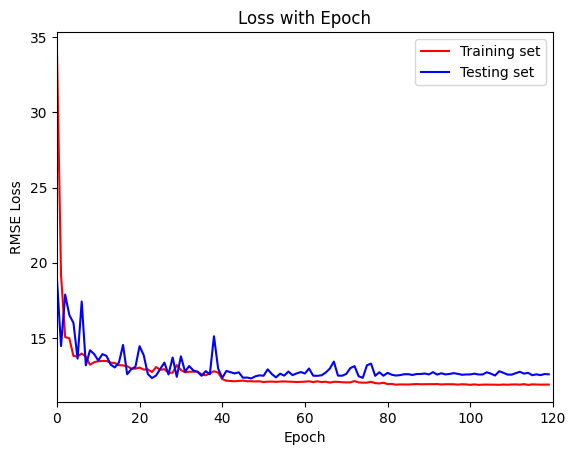

2024_05_25_03_03_38: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_03_38.pth
2024_05_25_03_03_38: Evaluating the final model
Testing RMSE: 13.204515049956248
Testing Score: 29781.591569193493
Testing Accuracy: 0.7234893957583033
Testing RMSE for the end of samples: 12.715795996119004
Testing Score for the end of samples: 283.2860195156295
Testing Accuracy for the end of samples: 0.7171717171717171
2024_05_25_03_04_06: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:04:06,864] Trial 0 finished with value: 12.715795996119004 and parameters: {}. Best is trial 0 with value: 12.715795996119004.
2024_05_25_03_04_06: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.32205741992895
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.37623728876528
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.37859720423602
Testing RMSE:105.58104329109192
epoch: 3
Train

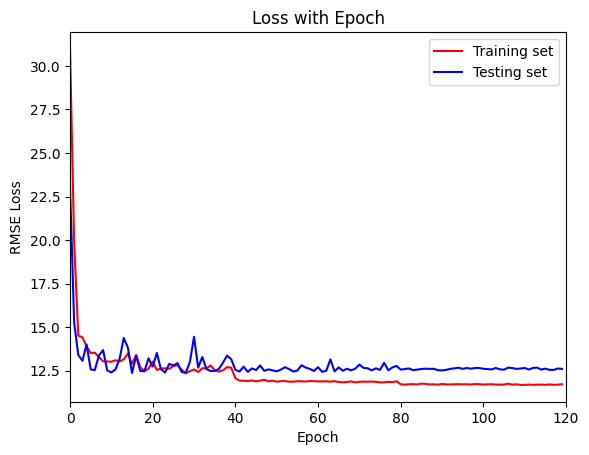

2024_05_25_03_08_14: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_08_14.pth
2024_05_25_03_08_14: Evaluating the final model
Testing RMSE: 13.353189008078903
Testing Score: 31954.8849068536
Testing Accuracy: 0.7031812725090036
Testing RMSE for the end of samples: 12.71170240337468
Testing Score for the end of samples: 312.35885373578736
Testing Accuracy for the end of samples: 0.6565656565656566
2024_05_25_03_08_43: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:08:43,211] Trial 2 finished with value: 12.71170240337468 and parameters: {}. Best is trial 2 with value: 12.71170240337468.
2024_05_25_03_08_43: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.39638873114102
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.32433507062387
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.38739080014436
Testing RMSE:105.58104329109192
epoch: 3
Training 

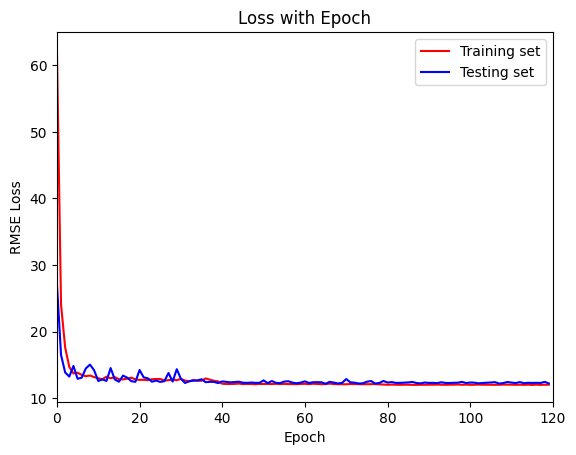

2024_05_25_03_12_50: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_12_50.pth
2024_05_25_03_12_50: Evaluating the final model
Testing RMSE: 13.010072415352672
Testing Score: 32455.973249454033
Testing Accuracy: 0.7072829131652661
Testing RMSE for the end of samples: 13.251574863478083
Testing Score for the end of samples: 336.148262747474
Testing Accuracy for the end of samples: 0.6464646464646465
2024_05_25_03_13_19: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:13:19,257] Trial 4 finished with value: 13.251574863478083 and parameters: {}. Best is trial 2 with value: 12.71170240337468.
2024_05_25_03_13_19: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.33244898699331
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.38130961984828
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.3473776112432
Testing RMSE:105.58104329109192
epoch: 3
Training

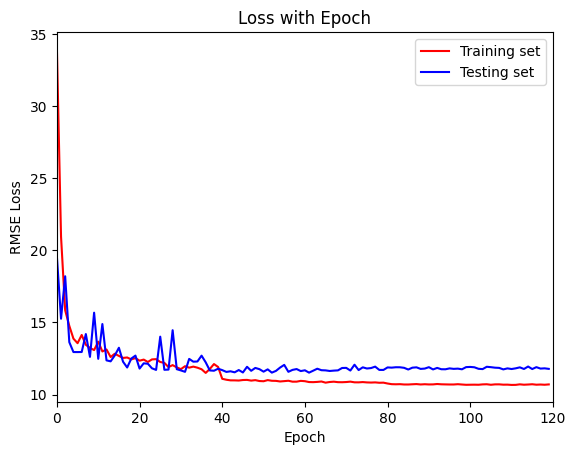

2024_05_25_03_17_26: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_17_26.pth
2024_05_25_03_17_26: Evaluating the final model
Testing RMSE: 12.406952339190758
Testing Score: 26397.680916303005
Testing Accuracy: 0.7398959583833533
Testing RMSE for the end of samples: 12.12795176468263
Testing Score for the end of samples: 261.8528603250659
Testing Accuracy for the end of samples: 0.696969696969697
2024_05_25_03_17_55: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:17:55,211] Trial 6 finished with value: 12.12795176468263 and parameters: {}. Best is trial 6 with value: 12.12795176468263.
2024_05_25_03_17_55: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 52.99135799684386
Testing RMSE:25.514661836624146
epoch: 1
Training RMSE: 24.13679255609927
Testing RMSE:19.912348866462708
epoch: 2
Training RMSE: 21.035093307495117
Testing RMSE:18.748544585704803
epoch: 3
Training

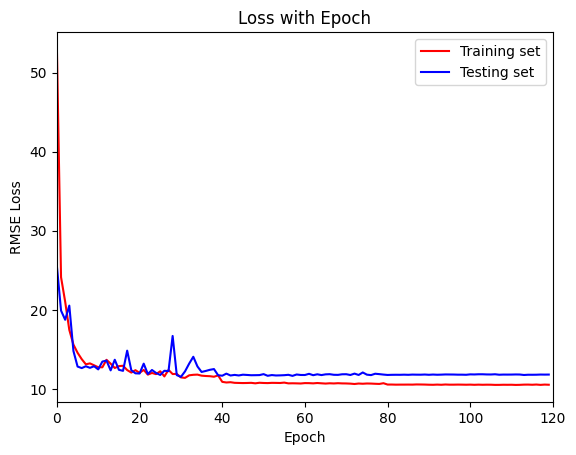

2024_05_25_03_21_16: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_21_16.pth
2024_05_25_03_21_16: Evaluating the final model
Testing RMSE: 12.461878523078274
Testing Score: 27040.763548475676
Testing Accuracy: 0.734093637454982
Testing RMSE for the end of samples: 12.33653149681624
Testing Score for the end of samples: 258.03719073468073
Testing Accuracy for the end of samples: 0.6565656565656566
2024_05_25_03_21_44: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:21:44,983] Trial 7 finished with value: 12.33653149681624 and parameters: {}. Best is trial 6 with value: 12.12795176468263.
2024_05_25_03_21_44: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.39741925225742
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.34997459079908
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.33636220296223
Testing RMSE:105.58104329109192
epoch: 3
Training

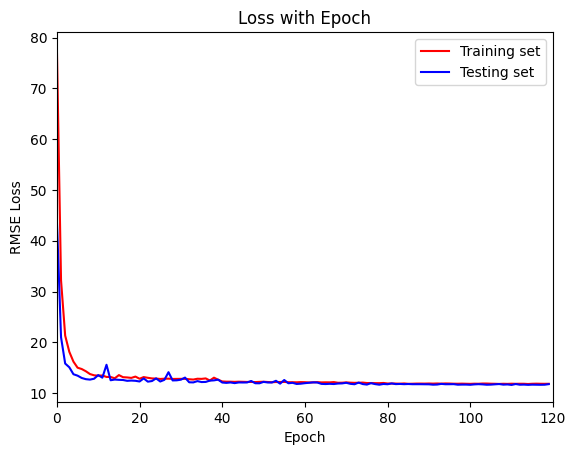

2024_05_25_03_25_53: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_25_53.pth
2024_05_25_03_25_53: Evaluating the final model
Testing RMSE: 12.50685119053295
Testing Score: 25113.098717113702
Testing Accuracy: 0.7237895158063226
Testing RMSE for the end of samples: 12.05413365452016
Testing Score for the end of samples: 233.31603570478552
Testing Accuracy for the end of samples: 0.6868686868686869
2024_05_25_03_26_21: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:26:21,645] Trial 9 finished with value: 12.05413365452016 and parameters: {}. Best is trial 9 with value: 12.05413365452016.
2024_05_25_03_26_21: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.37576338173686
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.32876653256623
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.36354728367017
Testing RMSE:105.58104329109192
epoch: 3
Training

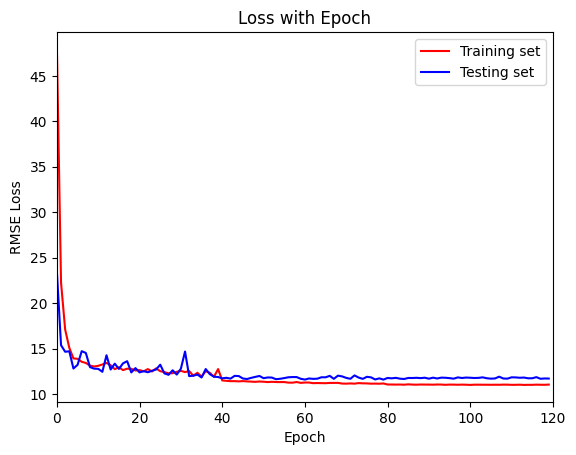

2024_05_25_03_31_16: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_31_16.pth
2024_05_25_03_31_16: Evaluating the final model
Testing RMSE: 12.347301349093257
Testing Score: 25766.71926543943
Testing Accuracy: 0.7342937174869948
Testing RMSE for the end of samples: 12.12536946725659
Testing Score for the end of samples: 279.2014538896928
Testing Accuracy for the end of samples: 0.6868686868686869
2024_05_25_03_31_44: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:31:44,803] Trial 12 finished with value: 12.12536946725659 and parameters: {}. Best is trial 9 with value: 12.05413365452016.
2024_05_25_03_31_44: Training model starts -----------------------------------------------
epoch: 0
Training RMSE: 90.40137935030288
Testing RMSE:105.58104329109192
epoch: 1
Training RMSE: 90.40275673244311
Testing RMSE:105.58104329109192
epoch: 2
Training RMSE: 90.38255099973817
Testing RMSE:105.58104329109192
epoch: 3
Training

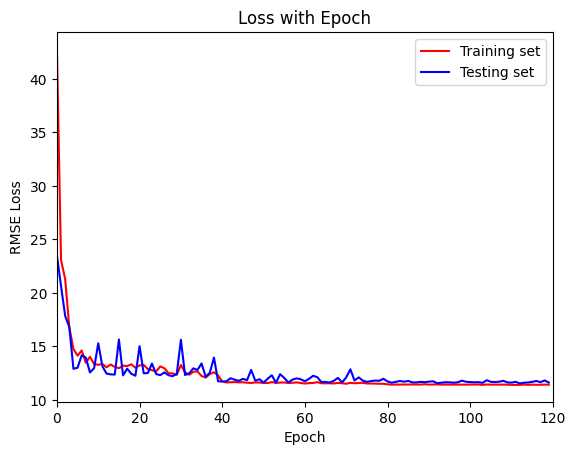

2024_05_25_03_35_52: Training completed. Model saved as DS-STFN_trained_120iter_2024_05_25_03_35_52.pth
2024_05_25_03_35_52: Evaluating the final model
Testing RMSE: 12.320597294081864
Testing Score: 26011.85644124643
Testing Accuracy: 0.7363945578231292
Testing RMSE for the end of samples: 12.027814002744927
Testing Score for the end of samples: 246.96636857584957
Testing Accuracy for the end of samples: 0.7171717171717171
2024_05_25_03_36_21: Experiment evaluation completed
-----------------------------------------------
[I 2024-05-24 21:36:21,405] Trial 14 finished with value: 12.027814002744927 and parameters: {}. Best is trial 14 with value: 12.027814002744927.


12.027814002744927

In [16]:
def objective(trial):
    RMSE = main(trial)
    return RMSE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, timeout=40000, show_progress_bar=True)

study.best_params  # Optimal hyperparameters found during the search
study.best_value  # Objective function value corresponding to the best_params

In [17]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  0
  Number of complete trials:  15
Best trial:
  Value:  12.027814002744927
  Params: 


In [18]:
#Iteration Results Over Multiple Trials
optuna.visualization.plot_optimization_history(study)

In [19]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,state
0,0,12.715796,2024-05-24 21:00:16.392641,2024-05-24 21:04:06.864579,0 days 00:03:50.471938,COMPLETE
1,1,84.226906,2024-05-24 21:04:06.867446,2024-05-24 21:04:53.835828,0 days 00:00:46.968382,COMPLETE
2,2,12.711702,2024-05-24 21:04:53.838399,2024-05-24 21:08:43.211317,0 days 00:03:49.372918,COMPLETE
3,3,84.226906,2024-05-24 21:08:43.215053,2024-05-24 21:09:30.193899,0 days 00:00:46.978846,COMPLETE
4,4,13.251575,2024-05-24 21:09:30.196835,2024-05-24 21:13:19.256990,0 days 00:03:49.060155,COMPLETE
5,5,84.226906,2024-05-24 21:13:19.260032,2024-05-24 21:14:06.178619,0 days 00:00:46.918587,COMPLETE
6,6,12.127952,2024-05-24 21:14:06.181207,2024-05-24 21:17:55.211409,0 days 00:03:49.030202,COMPLETE
7,7,12.336531,2024-05-24 21:17:55.214745,2024-05-24 21:21:44.983707,0 days 00:03:49.768962,COMPLETE
8,8,84.226906,2024-05-24 21:21:44.986383,2024-05-24 21:22:32.081477,0 days 00:00:47.095094,COMPLETE
9,9,12.054134,2024-05-24 21:22:32.084484,2024-05-24 21:26:21.645594,0 days 00:03:49.561110,COMPLETE


In [20]:
optuna.visualization.plot_slice(study)

In [21]:
#Parameter Importance
#optuna.visualization.plot_param_importances(study)

In [22]:
optuna.visualization.plot_contour(study)

In [23]:
optuna.visualization.plot_parallel_coordinate(study)